# Imports necessários

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from numpy import mean
from numpy import std
from matplotlib import pyplot
import seaborn as sns

# Import dos dados

## Receitas

In [2]:
dados_receitas = pd.read_csv('data/dados_receitas.csv', sep=';')
dados_receitas.head()

,COD_RECEITA,DATA,COD_CONTRIBUINTE,VALOR_ARRECADADO,FONTE_DADOS
0,1722010101,2013-01-03,886cd0eabf5a18,185560.68,prefeitura municipal
1,1722010101,2013-01-04,886cd0eabf5a18,8081.80,prefeitura municipal
2,1722010101,2013-01-07,886cd0eabf5a18,4231.39,prefeitura municipal
3,1722010101,2013-01-08,886cd0eabf5a18,10536.53,prefeitura municipal
4,1722010101,2013-01-15,886cd0eabf5a18,103118.27,prefeitura municipal


# Feature Engineering

## Receitas

### Remoção dos outliers

In [176]:
# Converter a coluna 'DATA' para o tipo datetime
dados_receitas['DATA'] = pd.to_datetime(dados_receitas['DATA'])

# Extrair o ano e mês da coluna 'DATA' como novas features
dados_receitas['ANO_MES'] = dados_receitas['DATA'].dt.strftime('%Y-%m')

# Extrair o ano, mês e dia da coluna 'DATA' como novas features
dados_receitas['ANO'] = dados_receitas['DATA'].dt.year

Q1: 51.23
Q3: 1579.25
IQR: 1528.02
Limite inferior: -2240.7999999999997
Limite superior: 3871.2799999999997
Quantidade de registros sem outliers: 83736


<Axes: title={'center': 'VALOR_ARRECADADO'}, xlabel='[ANO]'>

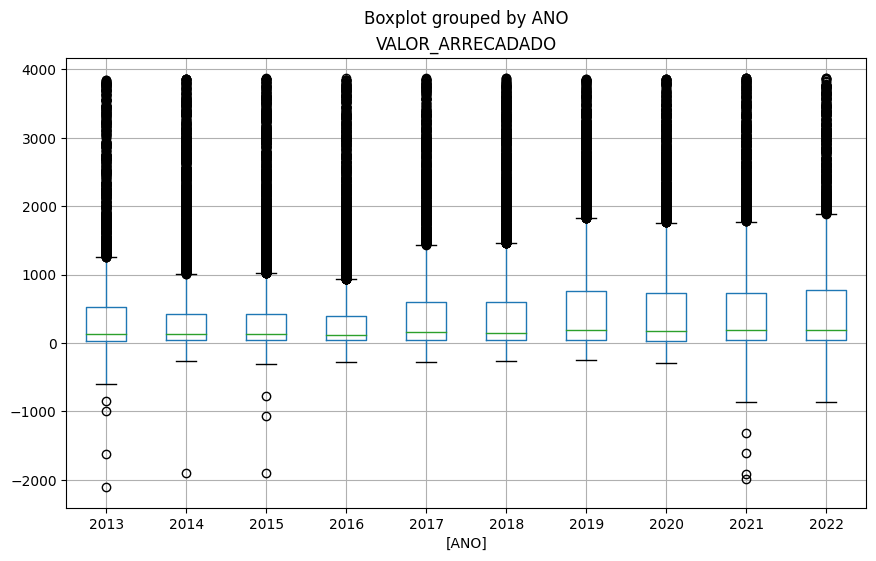

In [177]:
# aplicação de IQR - interquartile range
Q1 = dados_receitas['VALOR_ARRECADADO'].quantile(0.25)
Q3 = dados_receitas['VALOR_ARRECADADO'].quantile(0.75)
IQR = Q3 - Q1
print(f'Q1: {Q1}')
print(f'Q3: {Q3}')
print(f'IQR: {IQR}')

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
print(f'Limite inferior: {limite_inferior}')
print(f'Limite superior: {limite_superior}')

df_sem_outliers = dados_receitas[(dados_receitas['VALOR_ARRECADADO'] >= limite_inferior) & (dados_receitas['VALOR_ARRECADADO'] <= limite_superior)]
df_sem_outliers = df_sem_outliers[['ANO', 'VALOR_ARRECADADO']]
print(f'Quantidade de registros sem outliers: {df_sem_outliers.shape[0]}')
df_sem_outliers.boxplot(by='ANO', figsize=(10, 6))

In [178]:
df_sem_outliers = dados_receitas[(dados_receitas['VALOR_ARRECADADO'] >= limite_inferior) & (dados_receitas['VALOR_ARRECADADO'] <= limite_superior)]
df_sem_outliers.head()

,COD_RECEITA,DATA,COD_CONTRIBUINTE,VALOR_ARRECADADO,FONTE_DADOS,ANO_MES,ANO
8,9722010101,2013-01-04,886cd0eabf5a18,-1616.36,prefeitura municipal,2013-01,2013
10,9722010101,2013-01-08,886cd0eabf5a18,-2107.30,prefeitura municipal,2013-01,2013
18,1113050002,2013-01-31,886cd0eabf5a18,2075.64,prefeitura municipal,2013-01,2013
19,1113050002,2013-01-03,886cd0eabf5a18,111.96,prefeitura municipal,2013-01,2013
20,1113050002,2013-01-07,886cd0eabf5a18,57.17,prefeitura municipal,2013-01,2013


### Organizando dados por meses e ano

In [179]:
df_sem_outliers = df_sem_outliers.groupby(['ANO_MES', 'ANO'])['VALOR_ARRECADADO'].sum().reset_index()
df_sem_outliers.head()

,ANO_MES,ANO,VALOR_ARRECADADO
0,2013-01,2013,160122.33
1,2013-02,2013,125630.52
2,2013-03,2013,169281.06
3,2013-04,2013,161371.68
4,2013-05,2013,158982.66


In [180]:
df_sem_outliers.shape

(120, 3)

### Sample dos dados

In [181]:
df_sem_outliers['SMA(12)'] = df_sem_outliers['VALOR_ARRECADADO'].rolling(window=12).mean()
df_sem_outliers['SMA(6)'] = df_sem_outliers['VALOR_ARRECADADO'].rolling(window=6).mean()
df_sem_outliers['SMA(3)'] = df_sem_outliers['VALOR_ARRECADADO'].rolling(window=3).mean()
df_sem_outliers['SMA(2)'] = df_sem_outliers['VALOR_ARRECADADO'].rolling(window=2).mean()
df_sem_outliers.head()

,ANO_MES,ANO,VALOR_ARRECADADO,SMA(12),SMA(6),SMA(3),SMA(2)
0,2013-01,2013,160122.33,NaN,NaN,NaN,NaN
1,2013-02,2013,125630.52,NaN,NaN,NaN,142876.425
2,2013-03,2013,169281.06,NaN,NaN,151677.97,147455.790
3,2013-04,2013,161371.68,NaN,NaN,152094.42,165326.370
4,2013-05,2013,158982.66,NaN,NaN,163211.80,160177.170


In [182]:
df_sem_outliers['lag(12)'] = df_sem_outliers['VALOR_ARRECADADO'].shift(12)
df_sem_outliers['lag(6)'] = df_sem_outliers['VALOR_ARRECADADO'].shift(6)
df_sem_outliers['lag(4)'] = df_sem_outliers['VALOR_ARRECADADO'].shift(4)
df_sem_outliers['lag(3)'] = df_sem_outliers['VALOR_ARRECADADO'].shift(3)
df_sem_outliers['lag(2)'] = df_sem_outliers['VALOR_ARRECADADO'].shift(2)
df_sem_outliers['lag(1)'] = df_sem_outliers['VALOR_ARRECADADO'].shift(1)
df_sem_outliers.head()

,ANO_MES,ANO,VALOR_ARRECADADO,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1)
0,2013-01,2013,160122.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-02,2013,125630.52,NaN,NaN,NaN,142876.425,NaN,NaN,NaN,NaN,NaN,160122.33
2,2013-03,2013,169281.06,NaN,NaN,151677.97,147455.790,NaN,NaN,NaN,NaN,160122.33,125630.52
3,2013-04,2013,161371.68,NaN,NaN,152094.42,165326.370,NaN,NaN,NaN,160122.33,125630.52,169281.06
4,2013-05,2013,158982.66,NaN,NaN,163211.80,160177.170,NaN,NaN,160122.33,125630.52,169281.06,161371.68


In [183]:
df_sem_outliers.dropna(inplace=True)
df_sem_outliers.head()

,ANO_MES,ANO,VALOR_ARRECADADO,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1)
12,2014-01,2014,346286.48,240598.902500,317678.988333,353009.660000,334191.160,160122.33,216226.72,266534.19,313103.38,390646.66,322095.84
13,2014-02,2014,311117.66,256056.164167,324964.035000,326499.993333,328702.070,125630.52,267407.38,313103.38,390646.66,322095.84,346286.48
14,2014-03,2014,291347.62,266228.377500,329099.606667,316250.586667,301232.640,169281.06,266534.19,390646.66,322095.84,346286.48,311117.66
15,2014-04,2014,322734.71,279675.296667,330704.828333,308399.996667,307041.165,161371.68,313103.38,322095.84,346286.48,311117.66,291347.62
16,2014-05,2014,379210.98,298027.656667,328798.881667,331097.770000,350972.845,158982.66,390646.66,346286.48,311117.66,291347.62,322734.71


In [184]:
df_sem_outliers.drop(columns=['ANO'], inplace=True)

In [185]:
df_sem_outliers['ANO_MES'] = pd.to_datetime(df_sem_outliers['ANO_MES'])
df_sem_outliers['ANO_MES'] = df_sem_outliers['ANO_MES'].map(dt.datetime.toordinal)

### Implementação do modelo

In [186]:
train_size = int(len(df_sem_outliers) * 0.75)
train_dataset, test_dataset = df_sem_outliers.iloc[:train_size], df_sem_outliers.iloc[train_size:]

In [187]:
train_dataset.head()

,ANO_MES,VALOR_ARRECADADO,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1)
12,735234,346286.48,240598.902500,317678.988333,353009.660000,334191.160,160122.33,216226.72,266534.19,313103.38,390646.66,322095.84
13,735265,311117.66,256056.164167,324964.035000,326499.993333,328702.070,125630.52,267407.38,313103.38,390646.66,322095.84,346286.48
14,735293,291347.62,266228.377500,329099.606667,316250.586667,301232.640,169281.06,266534.19,390646.66,322095.84,346286.48,311117.66
15,735324,322734.71,279675.296667,330704.828333,308399.996667,307041.165,161371.68,313103.38,322095.84,346286.48,311117.66,291347.62
16,735354,379210.98,298027.656667,328798.881667,331097.770000,350972.845,158982.66,390646.66,346286.48,311117.66,291347.62,322734.71


Dimension of train data:  (81, 12)
Dimension of test data:  (27, 12)


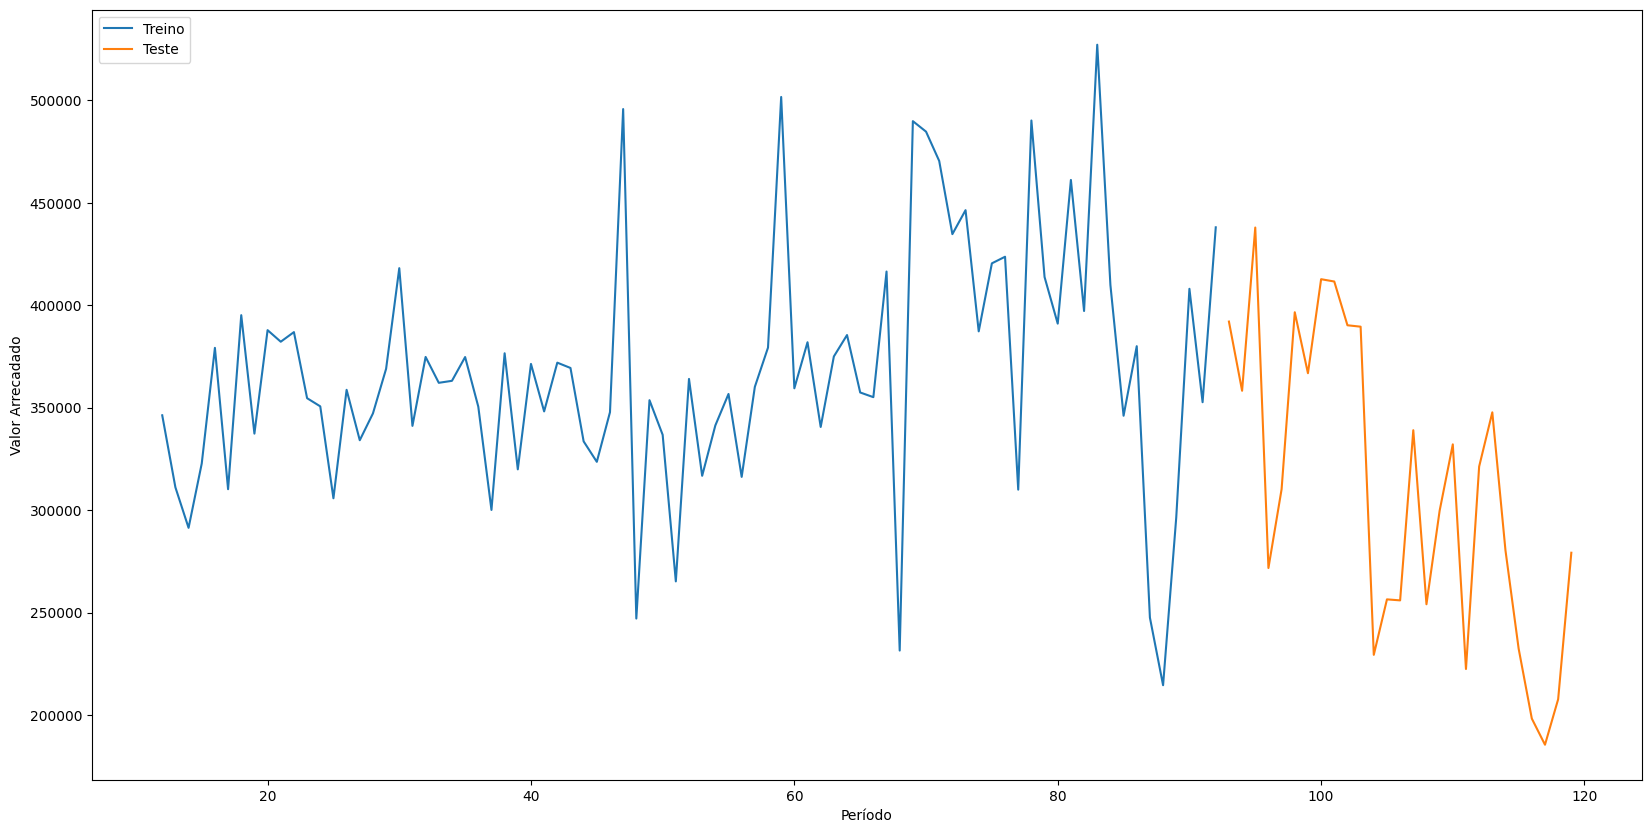

In [188]:
plt.figure(figsize=(20,10))
plt.plot(train_dataset['VALOR_ARRECADADO'])
plt.plot(test_dataset['VALOR_ARRECADADO'])
plt.xlabel('Período')
plt.ylabel('Valor Arrecadado')
plt.legend(['Treino', 'Teste'], loc='upper left')
print('Dimension of train data: ', train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [189]:
X_train = train_dataset.drop(['VALOR_ARRECADADO'], axis=1)
y_train = train_dataset.loc[:, ['VALOR_ARRECADADO']]

In [190]:
X_test = test_dataset.drop(['VALOR_ARRECADADO'], axis=1)
y_test = test_dataset.loc[:, ['VALOR_ARRECADADO']]

In [191]:
print('Dimension of X_train data: ', X_train.shape)
print('Dimension of y_train data: ', y_train.shape)
print('Dimension of X_test data: ', X_test.shape)
print('Dimension of y_test data: ', y_test.shape)

Dimension of X_train data:  (81, 11)
Dimension of y_train data:  (81, 1)
Dimension of X_test data:  (27, 11)
Dimension of y_test data:  (27, 1)


In [192]:
scaler_x = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

In [193]:
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

In [194]:
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

In [195]:
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [196]:
print('Dimension of train_y_norm data: ', train_x_norm.shape)
print('Dimension of train_x_norm data: ', train_y_norm.shape)
print('Dimension of test_y_norm data: ', test_x_norm.shape)
print('Dimension of test_x_norm data: ', test_y_norm.shape)

Dimension of train_y_norm data:  (81, 11)
Dimension of train_x_norm data:  (81, 1)
Dimension of test_y_norm data:  (27, 11)
Dimension of test_x_norm data:  (27, 1)


In [197]:
X_test = test_x_norm.reshape((test_x_norm.shape[0], 1, test_x_norm.shape[1]))
X_train = train_x_norm.reshape((train_x_norm.shape[0], 1, train_x_norm.shape[1]))
y_test = test_y_norm.reshape((test_y_norm.shape[0], 1))
y_train = train_y_norm.reshape((train_y_norm.shape[0], 1))

Ajuste no modelo com 32, 64 e 128 neurônios para verficação do mais adequado para a aplicação.

Epoch 1/100


16/16 [==============================] - 12s 130ms/step - loss: 0.1893 - val_loss: 0.1985
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0919 - val_loss: 0.0840
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0300 - val_loss: 0.0576
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0273 - val_loss: 0.0608
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0257 - val_loss: 0.0520
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0233 - val_loss: 0.0534
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0202 - val_loss: 0.0522
Epoch 8/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0225 - val_loss: 0.0516
Epoch 9/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0222 - val_loss: 0.0498
Epoch 10/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0214 - val_loss: 0.0492
Epoch 11/100
16

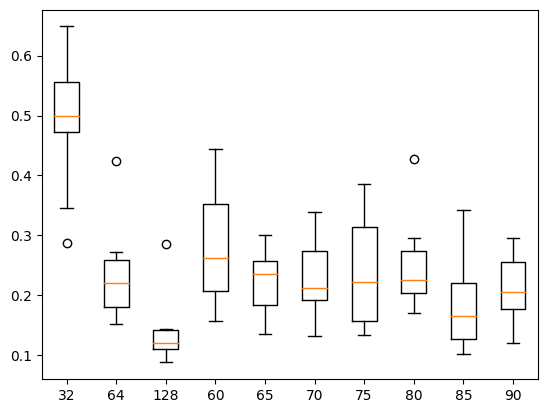

In [25]:
# Ajustando e validando o modelo
def evaluate_model(X_train, y_train, X_test, y_test, neurons):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units = neurons, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.LSTM(units = neurons))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(units = 1))
    # compilando o modelo
    model.compile(loss='mse', optimizer='adam')
    # ajustando o modelo
    model.fit(X_train, y_train, epochs=100, batch_size=4, validation_split = 0.2, shuffle=False)
    # avaliando o modelo
    loss = model.evaluate(X_test, y_test, verbose=0, batch_size=4)
    return loss

# Resumindo as pontuações
def summarize_results(scores, params):
    print(scores, params)
    # resumindo a média e desvio padrão
    for i in range(len(scores)):
        m, s = mean(scores[i]), std(scores[i])
        print(f'Param={params[i]}, Mean={m:.3f}, Std={s:.3f}')
    # boxplot das pontuações
    pyplot.boxplot(scores, labels=params)
    pyplot.savefig('src/static/images/figura[0].png')

# Rodando um experimento
def run_experiment(params, repeats = 10):
    # Testando cada parâmetro
    all_scores = list()
    for p in params:
        # repetindo o experimento
        scores = list()
        for r in range(repeats):
            score = evaluate_model(X_train, y_train, X_test, y_test, p)
            score = score * 100.0
            scores.append(score)
            print(f'>Neurons={p}, Score={score}')
        all_scores.append(scores)
    # resumindo os resultados
    summarize_results(all_scores, params)

# Rodando o experimento
n_params = [32, 64, 128, 60, 65, 70, 75, 80, 85, 90]
run_experiment(n_params)

Ajuste de modelo com tamanho do lote 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11 e 12, para verificação do mais adequado para a aplicação.

Epoch 1/50
64/64 [==============================] - 6s 22ms/step - loss: 0.0624 - val_loss: 0.0561
Epoch 2/50
64/64 [==============================] - 0s 7ms/step - loss: 0.0224 - val_loss: 0.0640
Epoch 3/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0211 - val_loss: 0.0591
Epoch 4/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0197 - val_loss: 0.0523
Epoch 5/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0167 - val_loss: 0.0471
Epoch 6/50
64/64 [==============================] - 0s 5ms/step - loss: 0.0139 - val_loss: 0.0364
Epoch 7/50
64/64 [==============================] - 0s 5ms/step - loss: 0.0157 - val_loss: 0.0465
Epoch 8/50
64/64 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0308
Epoch 9/50
64/64 [==============================] - 0s 5ms/step - loss: 0.0126 - val_loss: 0.0285
Epoch 10/50
64/64 [==============================] - 0s 5ms/step - loss: 0.0073 - val_loss: 0.0201
Epoch 11/50
64/64 

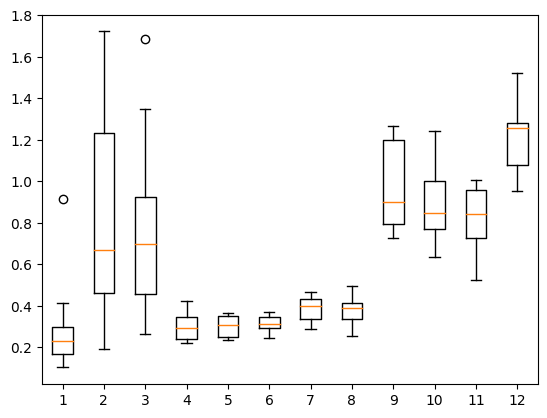

In [26]:
# Ajustando e validando o modelo
def evaluate_model(X_train, y_train, X_test, y_test, batch_size):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units = 80, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.LSTM(units = 80))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(units = 1))
    # compilando o modelo
    model.compile(loss='mse', optimizer='adam')
    # ajustando o modelo
    model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_split = 0.2, shuffle=False)
    # avaliando o modelo
    loss = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)
    return loss

# Resumindo as pontuações
def summarize_results(scores, params):
    print(scores, params)
    # resumindo a média e desvio padrão
    for i in range(len(scores)):
        m, s = mean(scores[i]), std(scores[i])
        print(f'Param={params[i]}, Mean={m:.3f}, Std={s:.3f}')
    # boxplot das pontuações
    pyplot.boxplot(scores, labels=params)
    pyplot.savefig('src/static/images/figura[1].png')

# Rodando um experimento
def run_experiment(params, repeats = 10):
    # Testando cada parâmetro
    all_scores = list()
    for p in params:
        # repetindo o experimento
        scores = list()
        for r in range(repeats):
            score = evaluate_model(X_train, y_train, X_test, y_test, p)
            score = score * 100.0
            scores.append(score)
            print(f'>p={p}: {r+1}, Score={score}')
        all_scores.append(scores)
    # resumindo os resultados
    summarize_results(all_scores, params)

# Rodando o experimento
n_params = np.arange(1, 13)
run_experiment(n_params)

Ajuste no modelo com diluição - dropout - 0.05, 0.1, 0.2, 0.3, para verficação do mais adequado para a aplicação.

Epoch 1/50
13/13 [==============================] - 7s 105ms/step - loss: 0.1824 - val_loss: 0.1576
Epoch 2/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0517 - val_loss: 0.0539
Epoch 3/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0292 - val_loss: 0.0683
Epoch 4/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0215 - val_loss: 0.0494
Epoch 5/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0218 - val_loss: 0.0529
Epoch 6/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0190 - val_loss: 0.0513
Epoch 7/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0195 - val_loss: 0.0495
Epoch 8/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0199 - val_loss: 0.0486
Epoch 9/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0184 - val_loss: 0.0467
Epoch 10/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0176 - val_loss: 0.0440
Epoch 11/5

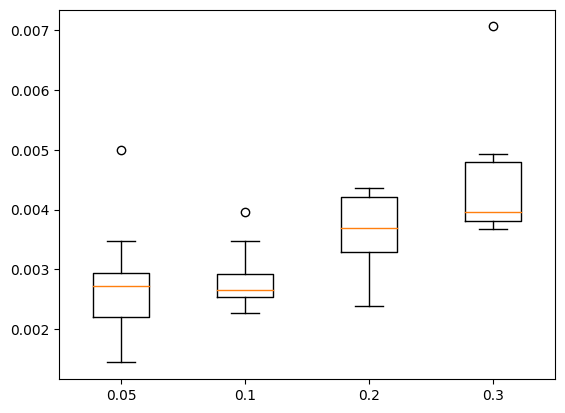

In [27]:
# Ajustando e validando o modelo
def evaluate_model(X_train, y_train, X_test, y_test, dropout):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units = 80, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.LSTM(units = 80))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(units = 1))
    # compilando o modelo
    model.compile(loss='mse', optimizer='adam')
    # ajustando o modelo
    model.fit(X_train, y_train, epochs=50, batch_size=5, validation_split = 0.2, shuffle=False)
    # avaliando o modelo
    loss = model.evaluate(X_test, y_test, verbose=0, batch_size=5)
    return loss

# Resumindo as pontuações
def summarize_results(scores, params):
    print(scores, params)
    # resumindo a média e desvio padrão
    for i in range(len(scores)):
        m, s = mean(scores[i]), std(scores[i])
        print(f'Param={params[i]}, Mean={m:.3f}:, Std={s:.3f}')
    # boxplot das pontuações
    pyplot.boxplot(scores, labels=params)
    pyplot.savefig('src/static/images/figura[2].png')

# Rodando um experimento
def run_experiment(params, repeats = 10):
    # Testando cada parâmetro
    all_scores = list()
    for p in params:
        # repetindo o experimento
        scores = list()
        for r in range(repeats):
            score = evaluate_model(X_train, y_train, X_test, y_test, p)
            score = score
            scores.append(score)
            print(f'>p={p}: {r+1}, Score={score}')
        all_scores.append(scores)
    # resumindo os resultados
    summarize_results(all_scores, params)

# Rodando o experimento
n_params = [0.05, 0.1, 0.2, 0.3]
run_experiment(n_params)

Ajustando o modelo com os padrões mais adequados visualizados nos testes anteriores.

<p>Neurônios = 90</p>
<p>Tamanho do lote/batch = 4</p>
<p>Dopout = 0.05</p>

In [198]:
# Ajustando e validando o modelo
def evaluate_model(X_train, y_train, X_test, y_test):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units = 90, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.Dropout(0.05))
    model.add(tf.keras.layers.LSTM(units = 90))
    model.add(tf.keras.layers.Dropout(0.05))
    model.add(tf.keras.layers.Dense(units = 1))
    # compilando o modelo
    model.compile(loss='mse', optimizer='adam')
    # ajustando o modelo
    model.fit(X_train, y_train, epochs=150, batch_size=4, validation_split = 0.2, shuffle=False)
    # avaliando o modelo
    loss = model.evaluate(X_test, y_test, verbose=0, batch_size=4)
    return loss

# Resumindo as pontuações
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print(f'Loss: Mean = {m:.3f}, Std = {s:.3f}')

# Rodando um experimento
def run_experiment(repeats = 10):
    # repetindo o experimento
    scores = list()
    for r in range(repeats):
        score = evaluate_model(X_train, y_train, X_test, y_test)
        score = score
        scores.append(score)
        print(f'>{r+1}: Score={score}')
    # resumindo os resultados
    summarize_results(scores)

# Rodando o experimento
run_experiment()

Epoch 1/150
16/16 [==============================] - 10s 162ms/step - loss: 0.1587 - val_loss: 0.1014
Epoch 2/150
16/16 [==============================] - 0s 14ms/step - loss: 0.0323 - val_loss: 0.0863
Epoch 3/150
16/16 [==============================] - 0s 14ms/step - loss: 0.0227 - val_loss: 0.0529
Epoch 4/150
16/16 [==============================] - 0s 13ms/step - loss: 0.0222 - val_loss: 0.0556
Epoch 5/150
16/16 [==============================] - 0s 18ms/step - loss: 0.0205 - val_loss: 0.0532
Epoch 6/150
16/16 [==============================] - 0s 16ms/step - loss: 0.0199 - val_loss: 0.0514
Epoch 7/150
16/16 [==============================] - 0s 15ms/step - loss: 0.0196 - val_loss: 0.0493
Epoch 8/150
16/16 [==============================] - 0s 14ms/step - loss: 0.0187 - val_loss: 0.0474
Epoch 9/150
16/16 [==============================] - 0s 12ms/step - loss: 0.0192 - val_loss: 0.0462
Epoch 10/150
16/16 [==============================] - 0s 16ms/step - loss: 0.0172 - val_loss: 0.04

Criando modelo:

In [199]:
def create_model(units, dropout):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units = units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.LSTM(units = units))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(units = 1))
    # compilando o modelo
    model.compile(loss='mse', optimizer='adam')
    return model

In [200]:
model_lstm = create_model(90, 0.05)

In [201]:
def fit_model(model):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history = model.fit(X_train, y_train, epochs=150, batch_size=4, validation_split = 0.2, shuffle=False, callbacks=[early_stop])
    return history

In [202]:
history_lstm = fit_model(model_lstm)

Epoch 1/150


16/16 [==============================] - 12s 140ms/step - loss: 0.1341 - val_loss: 0.0747
Epoch 2/150
16/16 [==============================] - 0s 12ms/step - loss: 0.0296 - val_loss: 0.0769
Epoch 3/150
16/16 [==============================] - 0s 13ms/step - loss: 0.0223 - val_loss: 0.0523
Epoch 4/150
16/16 [==============================] - 0s 13ms/step - loss: 0.0217 - val_loss: 0.0540
Epoch 5/150
16/16 [==============================] - 0s 12ms/step - loss: 0.0211 - val_loss: 0.0517
Epoch 6/150
16/16 [==============================] - 0s 15ms/step - loss: 0.0189 - val_loss: 0.0515
Epoch 7/150
16/16 [==============================] - 0s 13ms/step - loss: 0.0194 - val_loss: 0.0493
Epoch 8/150
16/16 [==============================] - 0s 14ms/step - loss: 0.0194 - val_loss: 0.0465
Epoch 9/150
16/16 [==============================] - 0s 13ms/step - loss: 0.0189 - val_loss: 0.0461
Epoch 10/150
16/16 [==============================] - 0s 13ms/step - loss: 0.0171 - val_loss: 0.0433
Epoch 11/

Salvando modelo:

In [203]:
model_lstm.save('receitas_2013_2022')

INFO:tensorflow:Assets written to: receitas_2013_2022\assets


INFO:tensorflow:Assets written to: receitas_2013_2022\assets


Carga do modelo salvo:

In [204]:
model_lstm = tf.keras.models.load_model('receitas_2013_2022')

Pré-processamento e predição da base de testes com a utilização do modelo carregado:

In [205]:
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [206]:
def prediction(model):
    y_pred = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred)
    return y_pred

In [207]:
prediction_lstm = prediction(model_lstm)

1/1 [==============================] - 2s 2s/step


In [208]:
def plot_future(prediction, y_test):
    plt.figure(figsize=(10,6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='Dados reais')
    plt.plot(np.arange(range_future), np.array(prediction),label='Predição')
    plt.legend(loc='upper left')
    plt.xlabel('Período')
    plt.ylabel('Valor Arrecadado')
    plt.title('Predição de Receitas - LSTM')
    plt.savefig('src/static/images/figura[3].png')
    plt.show()

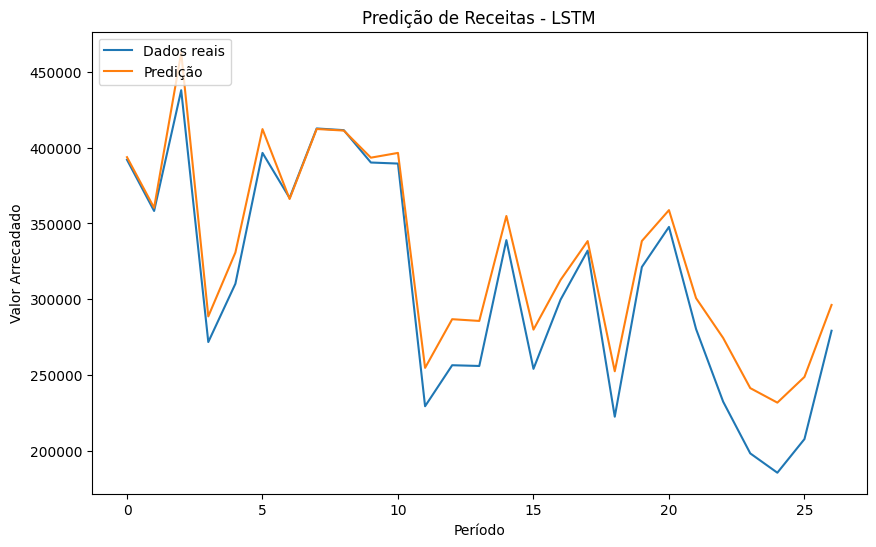

In [209]:
plot_future(prediction_lstm, y_test)

Cálculo do erro médio absoluto e raiz quadrática média:

In [210]:
def evaluate_prediction(prediction_lstm, actual, model_name):
    errors = prediction_lstm - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(f'{model_name}:')
    print(f'MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}')

In [211]:
evaluate_prediction(prediction_lstm, y_test, 'LSTM')

LSTM:
MSE: 544206870.54, RMSE: 23328.24, MAE: 18815.15


Pré-processamento dos dados e aplicação do modelo em toda a base de dados (treino + teste):

In [212]:
X = df_sem_outliers.drop(['VALOR_ARRECADADO'], axis=1)
y = df_sem_outliers.loc[:, ['VALOR_ARRECADADO']]

In [213]:
y_norm = output_scaler.transform(y)
X_norm = input_scaler.transform(X)

In [214]:
X = X_norm.reshape((X_norm.shape[0], 1, X_norm.shape[1]))
y = y_norm.reshape((y_norm.shape[0], 1))

In [215]:
y = scaler_y.inverse_transform(y)

In [216]:
def prediction(model):
    y_pred = model.predict(X)
    y_pred = scaler_y.inverse_transform(y_pred)
    return y_pred

In [217]:
prediction_lstm = prediction(model_lstm)

4/4 [==============================] - 0s 8ms/step


In [218]:
def plot_future(prediction, y):
    plt.figure(figsize=(10,6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y), label='Dados reais')
    plt.plot(np.arange(range_future), np.array(prediction),label='Predição')
    plt.legend(loc='upper left')
    plt.xlabel('Período')
    plt.ylabel('Valor Arrecadado')
    plt.title('Predição de Receitas - LSTM')
    plt.savefig('src/static/images/figura[4].png')
    plt.show()

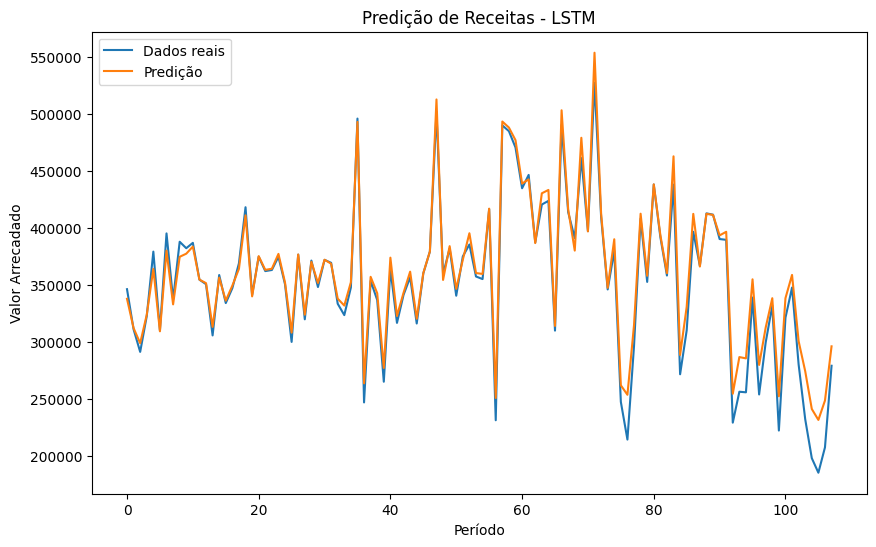

In [219]:
plot_future(prediction_lstm, y)

Cálculo do erro médio percentual:

In [220]:
real = y.flatten()
previsto = prediction_lstm.flatten()

In [221]:
tabela = pd.DataFrame([real, previsto]).T
tabela = tabela.rename(columns={0: 'Real', 1: 'Previsto'})
tabela['Diferenca'] = 1 - (tabela['Real'] / tabela['Previsto'])
media_tabela = tabela['Diferenca'].mean() * 100
print(f'Erro médio percentual: {media_tabela:.2f}%')

Erro médio percentual: 2.40%


Distribuição de erros:

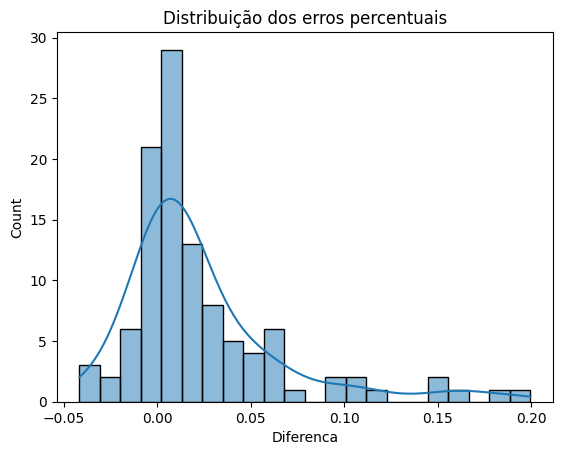

In [222]:
sns.histplot(data=tabela, x='Diferenca', kde=True).set_title('Distribuição dos erros percentuais').get_figure().savefig('src/static/images/figura[5].png')

In [223]:
previsao = df_sem_outliers

In [224]:
previsao

,ANO_MES,VALOR_ARRECADADO,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1)
12,735234,346286.48,240598.902500,317678.988333,353009.660000,334191.160,160122.33,216226.72,266534.19,313103.38,390646.66,322095.84
13,735265,311117.66,256056.164167,324964.035000,326499.993333,328702.070,125630.52,267407.38,313103.38,390646.66,322095.84,346286.48
14,735293,291347.62,266228.377500,329099.606667,316250.586667,301232.640,169281.06,266534.19,390646.66,322095.84,346286.48,311117.66
15,735324,322734.71,279675.296667,330704.828333,308399.996667,307041.165,161371.68,313103.38,322095.84,346286.48,311117.66,291347.62
16,735354,379210.98,298027.656667,328798.881667,331097.770000,350972.845,158982.66,390646.66,346286.48,311117.66,291347.62,322734.71
...,...,...,...,...,...,...,...,...,...,...,...,...
115,738368,232355.13,280886.717500,289362.661667,286796.743333,256336.230,389543.34,299705.63,222432.57,321259.43,347717.77,280317.33
116,738399,198234.65,278293.558333,267052.813333,236969.036667,215294.890,229352.56,332093.74,321259.43,347717.77,280317.33,232355.13
117,738429,185469.57,272380.415000,260892.313333,205353.116667,191852.110,256427.29,222432.57,347717.77,280317.33,232355.13,198234.65
118,738460,207671.22,268358.575000,241960.945000,197125.146667,196570.395,255933.30,321259.43,280317.33,232355.13,198234.65,185469.57


In [225]:
periodo = 10  # escolha o período de previsão à frente será executado

for i in range(periodo):
    # Crie uma nova linha de dados vazia
    row = pd.DataFrame(columns=previsao.columns)

    # Calcule as médias e valores de atraso
    row.loc[0, 'SMA(12)'] = previsao['VALOR_ARRECADADO'].iloc[-12:].mean()
    row.loc[0, 'SMA(6)'] = previsao['VALOR_ARRECADADO'].iloc[-6:].mean()
    row.loc[0, 'SMA(3)'] = previsao['VALOR_ARRECADADO'].iloc[-3:].mean()
    row.loc[0, 'SMA(2)'] = previsao['VALOR_ARRECADADO'].iloc[-2:].mean()
    row.loc[0, 'lag(12)'] = previsao['VALOR_ARRECADADO'].iloc[-12]
    row.loc[0, 'lag(6)'] = previsao['VALOR_ARRECADADO'].iloc[-6]
    row.loc[0, 'lag(4)'] = previsao['VALOR_ARRECADADO'].iloc[-4]
    row.loc[0, 'lag(3)'] = previsao['VALOR_ARRECADADO'].iloc[-3]
    row.loc[0, 'lag(2)'] = previsao['VALOR_ARRECADADO'].iloc[-2]
    row.loc[0, 'lag(1)'] = previsao['VALOR_ARRECADADO'].iloc[-1]

    # Incremente a data
    row.loc[0, 'ANO_MES'] = previsao['ANO_MES'].iloc[-1]+1
    
    # Excluindo a coluna de valor arrecadado
    row = row.drop(['VALOR_ARRECADADO'], axis=1)
    
    # Transforme a linha em um array e normalize
    row = np.array(row.iloc[-1]).reshape(1, -1)
    row_norm = input_scaler.transform(row)

    # Preveja usando o modelo LSTM
    to_prev = row_norm.reshape((row_norm.shape[0], 1, row_norm.shape[1]))
    prev = model_lstm.predict(to_prev)
    prev = scaler_y.inverse_transform(prev)

    # Crie um DataFrame com a previsão e adicione ao DataFrame principal
    row_ = pd.DataFrame(row, columns = ['ANO_MES', 'SMA(12)', 'SMA(6)', 'SMA(3)', 'SMA(2)', 'lag(12)', 'lag(6)', 'lag(4)', 'lag(3)', 'lag(2)', 'lag(1)'])
    row_.loc[0, 'VALOR_ARRECADADO'] = prev[0]
    previsao = pd.concat([previsao, row_], ignore_index=True)

1/1 [==============================] - ETA: 0s

c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 57ms/step


c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 58ms/step


c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 49ms/step


c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


c:\Users\allys\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [226]:
previsao

,ANO_MES,VALOR_ARRECADADO,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1)
0,735234,346286.48000,240598.9025,317678.988333,353009.66,334191.16,160122.33,216226.72,266534.19,313103.38,390646.66,322095.84
1,735265,311117.66000,256056.164167,324964.035,326499.993333,328702.07,125630.52,267407.38,313103.38,390646.66,322095.84,346286.48
2,735293,291347.62000,266228.3775,329099.606667,316250.586667,301232.64,169281.06,266534.19,390646.66,322095.84,346286.48,311117.66
3,735324,322734.71000,279675.296667,330704.828333,308399.996667,307041.165,161371.68,313103.38,322095.84,346286.48,311117.66,291347.62
4,735354,379210.98000,298027.656667,328798.881667,331097.77,350972.845,158982.66,390646.66,346286.48,311117.66,291347.62,322734.71
...,...,...,...,...,...,...,...,...,...,...,...,...
113,738496,298642.28125,257486.232604,273011.520208,280460.822917,283869.8125,347717.77,279195.09,275591.375,273642.84375,275569.59375,292170.03125
114,738497,303178.71875,253396.608542,276252.71875,288793.96875,295406.15625,280317.33,241900.1875,273642.84375,275569.59375,292170.03125,298642.28125
115,738498,311259.59375,255301.724271,286465.807292,297997.010417,300910.5,232355.13,275591.375,275569.59375,292170.03125,298642.28125,303178.71875
116,738499,312998.65625,261877.09625,292410.510417,304360.197917,307219.15625,198234.65,273642.84375,292170.03125,298642.28125,303178.71875,311259.59375
